# Project: Analysis of Appointment No-Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Why do patients miss their scheduled appointments?  

Missed appointments lead to inefficient use of medical practitioners' time, disruption to the clinic workflow, increased waiting periods and can hinder optimal care. 

This project analyzes and explores the factors that may contribute to a patient not showing up to a scheduled medical appointment.  The dataset from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) uses appointment information from Brazil and contains the following fields:

* PatientID 
* AppointmentID
* Gender 
* ScheduledDay : the date the appointment was registered.  Should be prior to AppointmentDay
* AppointmentDay : date of appointment
* Age
* Neighbourhood : location of the hospital
* Scholarship : indicates whether or not the patient is enrolled in the Brazilian welfare program, Bolsa Familia
* Hipertension
* Diabetes
* Alcoholism
* Handcap
* SMS_received
* No-show : No = the patient attended the appointment, Yes = the patient was a no-show


#### Questions that will be explored are:
1. Do certain age groups of genders tend to miss appointments?
2. Are appointments more likely missed on certain days (just before or after the weekend)?
3. Does longer lead-time (the time between the day the appointment is scheduled and the actual appointment date) correlate with higher incidence of no-shows, maybe due to forgetfulness or recovery
4. Do sms reminders help lower the incidence of no-shows?
5. Are welfare holders likely to attend an appointment for fear of possibly losing welfare entitlement due to too many missed medical appointments, or are non-welfare holders more likely to attend an appointment as they would possibly have to pay a no-show fee out of their own pocket.
6. Could a patient's physical traits affect their ability to show up to their appointment?  Are patients with handicaps or suffering from alcoholism more likely to be a no-show due to inability and incapacity to attend their appointment?




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set_style('ticks')


<a id='wrangling'></a>
## Data Wrangling



### General Properties

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
sum(df.duplicated())

0

***
### Initial Screening and Cleaning

There are 110,527 records, each of 14 columns.  From the initial screening, there doesn't appear to be any missing or duplicated values and data looks relatively cleaned.  

These initial steps will be taken to prepare the data for ease of analysis and consistency:

1. AppointmentID will be dropped - This is just an index for the appointments - the generated dataframe index will be used
2. Column names will be changed for spelling errors and to pothole case (lower case separated by underscores)
3. 'ScheduledDay' and 'AppointmentDay' data type will be converted to datetime.date - the date will only be used since 'AppointmentDay' doesn't have a time

#### 1. Drop 'AppointmentID'

In [5]:
df.drop(['AppointmentID'], axis=1, inplace=True)
df.head(0)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [6]:
# Check for duplicates - A new AppointmentID may have been generated for the same appointment
sum(df.duplicated())

618

In [7]:
# Delete duplicates
df.drop_duplicates(inplace=True)
sum(df.duplicated())

0

***
#### 2. Clean column names for spelling errors and pothole case

In [8]:
# change column headers to lowercase and replace any hyphens (-) with underscores (_)
df.rename(columns = lambda x: x.strip().lower().replace('-', '_'), inplace=True)
df.head(0)

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show


In [9]:
# Rename any columns to make for easier reading and to correct any typos
df.rename(columns = {'patientid' : 'patient_id',
                    'scheduledday' : 'scheduled_day',
                    'appointmentday' : 'appointment_day',
                    'hipertension': 'hypertension',
                    'handcap' : 'handicap'}, inplace=True)
df.head(0)

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


***
#### 3. Change data type: 'scheduled_day' and 'appointment_day' to datetime.date
Take out the timestamp using this [removing the timestamp link](https://stackoverflow.com/questions/45858155/removing-the-timestamp-from-a-datetime-in-pandas-dataframe)

In [10]:
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']).dt.date
df['appointment_day'] = pd.to_datetime(df['appointment_day']).dt.date

type(df['scheduled_day'][1]), type(df['appointment_day'][1])

(datetime.date, datetime.date)

In [11]:
df.head()

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,2.987250e+13,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [12]:
# Check for duplicates now that the timestamp has been removed
sum(df.duplicated())

3604

In [13]:
# Delete duplicates
df.drop_duplicates(inplace=True)
sum(df.duplicated())

0

***
### Second Pass Screening and Data Cleaning

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106305 entries, 0 to 110526
Data columns (total 13 columns):
patient_id         106305 non-null float64
gender             106305 non-null object
scheduled_day      106305 non-null object
appointment_day    106305 non-null object
age                106305 non-null int64
neighbourhood      106305 non-null object
scholarship        106305 non-null int64
hypertension       106305 non-null int64
diabetes           106305 non-null int64
alcoholism         106305 non-null int64
handicap           106305 non-null int64
sms_received       106305 non-null int64
no_show            106305 non-null object
dtypes: float64(1), int64(7), object(5)
memory usage: 11.4+ MB


In [15]:
df.nunique()

patient_id         62299
gender                 2
scheduled_day        111
appointment_day       27
age                  104
neighbourhood         81
scholarship            2
hypertension           2
diabetes               2
alcoholism             2
handicap               5
sms_received           2
no_show                2
dtype: int64

In [16]:
df.describe()

,patient_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received
count,1.063050e+05,106305.000000,106305.000000,106305.000000,106305.000000,106305.000000,106305.000000,106305.000000
mean,1.467652e+14,37.116128,0.098067,0.198946,0.072744,0.027986,0.021890,0.333700
std,2.551511e+14,23.173480,0.297406,0.399210,0.259716,0.164932,0.160314,0.471536
min,3.921784e+04,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.151415e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.154590e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.433654e+13,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


From the second screening, the following will be addressed: 

1. Age: minimum age is -1, maximum age is 115.
   The minimum age is definitely an incorrect age and will need to be removed. The maximum age could be correct but will need to be checked to see if it is an outlier and inclusion might skew the result
   
2. What is the range of handicaps? According to the kaggle description, this should be a True/False datatype. 

3. Out of 106,305 appointments, there are only 62,299 unique patient ID's over a range of 27 appointment days.  This averages out at just under 2 appointments per patient over the sample period over 27 days and seems extreme and warrants further investigation


#### 1. Check and Clean Age Data

In [17]:
# Check for records where age is less than 0
df.query('age < 0')

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
99832,4.659432e+14,F,2016-06-06,2016-06-06,-1,ROMÃO,0,0,0,0,0,0,No


In [18]:
# Delete this record
df.drop(df.loc[df['age'] < 0].index, inplace=True)
df.query('age < 0')

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show


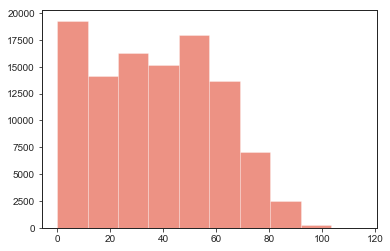

In [19]:
df['age'].hist(alpha=0.6, grid=False);

In [20]:
#Check number of patients over 100
len(df[df['age']>100])

6

In [21]:
#Check number of patients over 80
len(df[df['age']>80])

2752

In [22]:
# Percentage of sample aged over 80
len(df[df['age']>80])/len(df) * 100

2.588801926550271

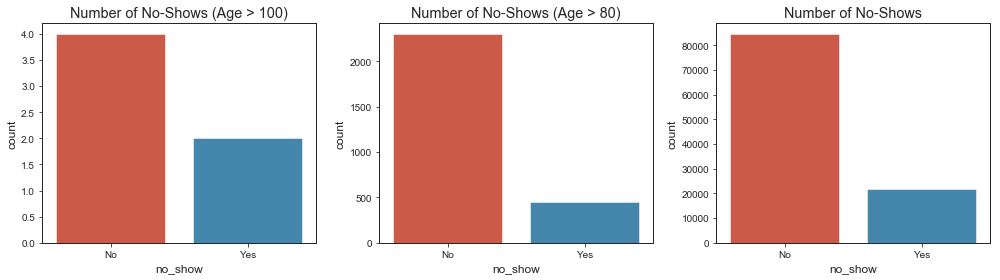

In [23]:
# Compare the distribution of no shows of
# * patients over 100 
# * patients over 80 
# * overall sample
figure,axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
sns.countplot(df[df['age']>100]['no_show'], ax=axes[0])
axes[0].set_title('Number of No-Shows (Age > 100)')

sns.countplot(df[df['age']>80]['no_show'], ax=axes[1])
axes[1].set_title('Number of No-Shows (Age > 80)')

sns.countplot(df['no_show'], ax=axes[2])
axes[2].set_title('Number of No-Shows')
plt.tight_layout();

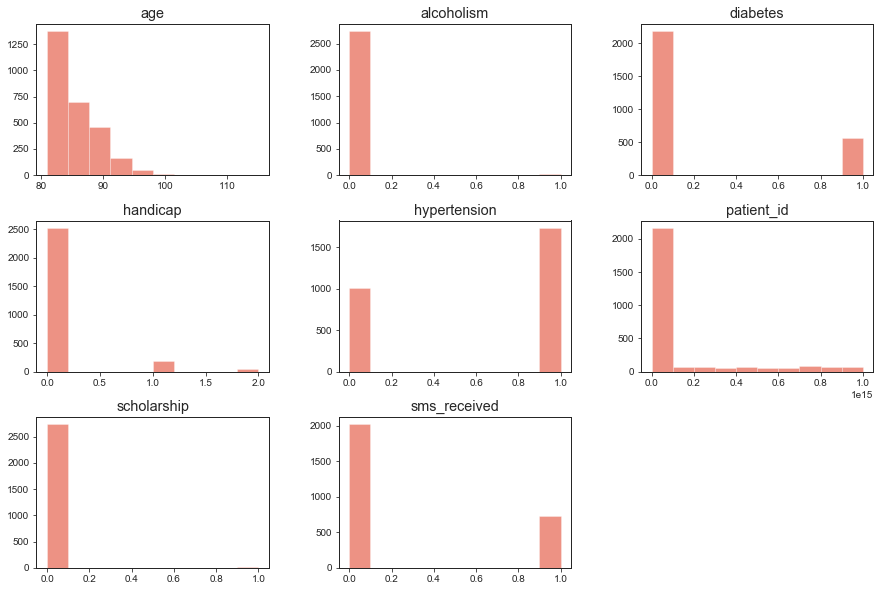

In [24]:
#Compare overall distributions of sample over 80 years and full dataset
# Distributions of sample aged greater than 80
df[df['age'] > 80].hist(figsize=(15,10), grid=False, alpha=0.6);

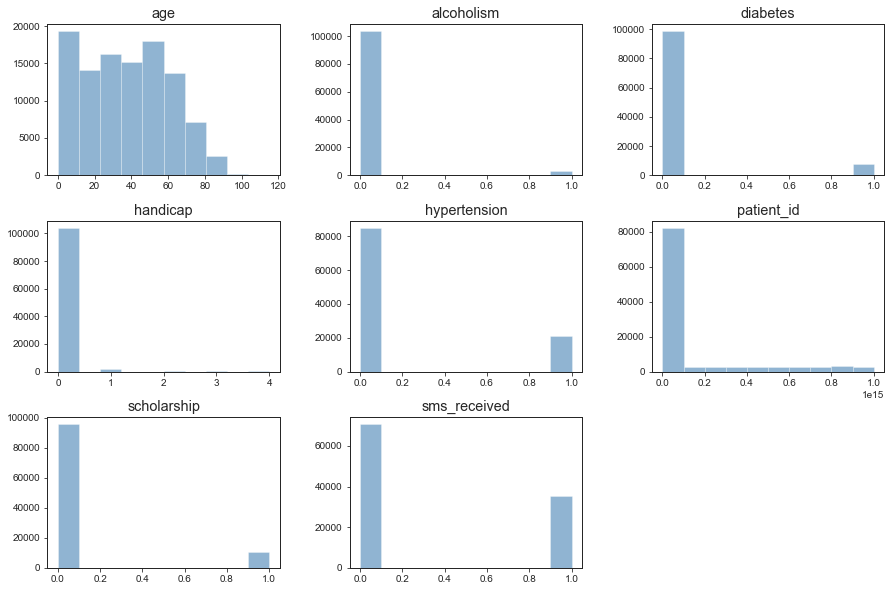

In [25]:
# Distributions of full dataset
df.hist(figsize=(15,10), color='steelblue', grid=False, alpha=0.6);

***_Age Data Cleaning Summary_***

There was only one record with age less than 0.  This was deleted.

There are only 6 appointments with patients older than 100. It is possible that these ages are correct. Even so, if these 6 records are grouped with those of age greater than 80 (sample size 2752, which is 2.6% of the full sample), their no-show and overall proportions (other than hypertension) are relatively consistent with the full dataset. Therefore, these records will be included in the analysis - they will not skew the data due to their small proportion as part of the full dataset, plus their ratios are consistent with the full dataset.

Should hypertension correlate with patient's no-show, then this may need to be re-visited due to the opposing ratio of the sub-group of older than 80


***
#### 2. Check and Clean Handicap data
The original data source states that this field is a binary True/False.  The range of number of handicaps will be investigated and decided whether it can be converted to binary data

In [26]:
# Range of handicap
df['handicap'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

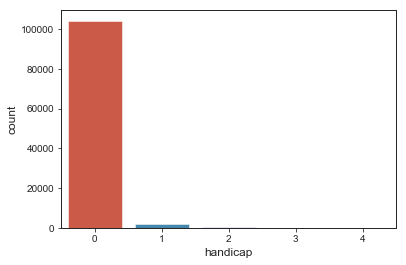

In [27]:
sns.countplot(df['handicap']);

In [28]:
# Percentage of No-Shows with more than one handicap
len(df.query('handicap > 0'))/len(df) * 100

1.9933398555087296

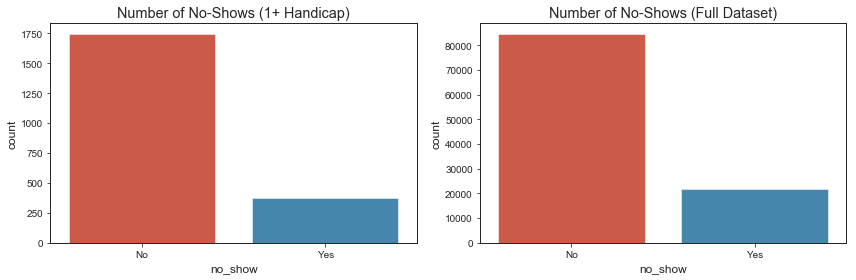

In [29]:
#Compare the distribution of no-shows between patients with more than 1 handicap and full dataset
figure,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.countplot(df.query('handicap > 0')['no_show'], ax=axes[0])
axes[0].set_title('Number of No-Shows (1+ Handicap)')

sns.countplot(df['no_show'], ax=axes[1])
axes[1].set_title('Number of No-Shows (Full Dataset)');

plt.tight_layout()

***_Handicap Data Cleaning Summary_***

The proportion  where handicap is greater than 1 is 2% of the full dataset.  Additionally the proportion of no-shows for 1+ handicaps is consistent with the proportion for the full dataset.  Therefore the handicap data will be transformed as a binary type - the variable is now whether one has any handicap vs. none

Data will be transformed:
Replace handicap : if 'handicap' greater than 0, then 'handicap' = 1 [link](https://stackoverflow.com/questions/31511997/pandas-dataframe-replace-all-values-in-a-column-based-on-condition)

In [30]:
df['handicap'].value_counts()

0    104185
1      1928
2       177
3        11
4         3
Name: handicap, dtype: int64

In [31]:
#Transform 'handicap' field to binary
df.loc[df['handicap'] > 0, 'handicap'] = 1
df['handicap'].value_counts()

0    104185
1      2119
Name: handicap, dtype: int64

***
#### 3. Check and Clean possible duplication of Appointments

There are 106k appointments for 62k patients over 27 days.  
Although the duplicate records have already been deleted, there is a possibility that only some parts of a record are duplicated and therefore remain.  

_Check for duplicates on 'patient id' and 'appointment day'_


In [32]:
df.duplicated(['patient_id', 'appointment_day']).value_counts()

False    101807
True       4497
dtype: int64

_Cycle through some variables relating to patient traits and details to see if they affect this result_

In [33]:
#Check Neighbourhood
df.duplicated(['patient_id', 'appointment_day', 'neighbourhood']).value_counts()

False    101807
True       4497
dtype: int64

In [34]:
# Check scholarship
df.duplicated(['patient_id', 'appointment_day', 'scholarship']).value_counts()

False    101807
True       4497
dtype: int64

In [35]:
# Check hypertension
df.duplicated(['patient_id', 'appointment_day', 'hypertension']).value_counts()

False    101807
True       4497
dtype: int64

In [36]:
# Check diabetes
df.duplicated(['patient_id', 'appointment_day', 'diabetes']).value_counts()

False    101807
True       4497
dtype: int64

In [37]:
# Check handicap
df.duplicated(['patient_id', 'appointment_day', 'handicap']).value_counts()

False    101807
True       4497
dtype: int64

In [38]:
# Check alcoholism
df.duplicated(['patient_id', 'appointment_day', 'alcoholism']).value_counts()

False    101807
True       4497
dtype: int64

Duplicates are not caused by any discrepancies in patient details

_Check for duplicates caused by new creation of an appointment already in the system, perhaps caused by human error or how the system handles re-scheduling appointments_

In [39]:
df.duplicated(['patient_id', 'appointment_day', 'scheduled_day']).value_counts()

False    104495
True       1809
dtype: int64

_Perhaps for some reason a new appointment is generated when an sms is received_

In [40]:
df.duplicated(['patient_id', 'appointment_day', 'sms_received']).value_counts()

False    104514
True       1790
dtype: int64

In [41]:
df.duplicated(['patient_id', 'appointment_day', 'scheduled_day', 'sms_received']).value_counts()

False    105946
True        358
dtype: int64

***_Appointment Duplication Summary_***

There appears to be duplication of appointments when searched by 'patient_id' plus 'appointment_day'.  It accounts for about 4% of the dataset and will be kept, as it is beyond my capabilities to determine which of the duplicated records to keep - do I keep the records that have no-shows?  do I keep the records with sms?  do I keep the records with the earlier scheduled date?

Duplication may have occured during rescheduling an appointment, when an appointment was not easily found in the system and was therefore re-entered or triggered somehow by when an sms reminder was sent.

Furthermore, I was not able to find answers as to why there was a large number of appointments for just over half that number of patients.  

<a id='eda'></a>
## Exploratory Data Analysis





_First subdivide the data into those who didn't show up and those who attended the appointment_

In [42]:
didnt_show = df.query('no_show == "Yes"')
attended=df.query('no_show == "No"')

### Q1. Gender and Age vs. No-shows

1. Is one gender more conscientious about attending their appointment?
2. Do certain age groups tend to miss appointments - perhaps working age groups tend to have more unforeseen commitments that prevent them from attending their appointments. 


#### 1. Gender Analysis
A simple analysis of gender effect on no-show rates

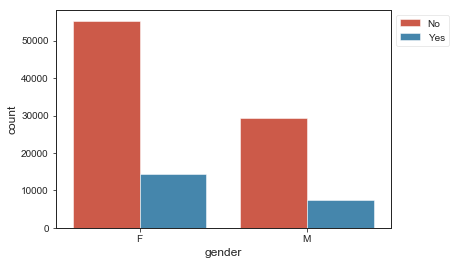

In [43]:
sns.countplot(x='gender', data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1));


In [44]:
print(df.groupby('gender')['no_show'].value_counts())
print(df.groupby('gender')['no_show'].value_counts(normalize=True))

gender  no_show
F       No         55324
        Yes        14263
M       No         29290
        Yes         7427
Name: no_show, dtype: int64
gender  no_show
F       No         0.795034
        Yes        0.204966
M       No         0.797723
        Yes        0.202277
Name: no_show, dtype: float64


**_Gender Summary_**

Females account for about two-thirds of the appointment holders.  The incidence of no-shows is however relatively the same in terms of proportion of appointments for both genders (approximately 20% of appointments). 

Gender by itself does not correlate or can be a predictor of whether a patient will be a no-show.

***
#### 2. Age Analysis

_Plot the distribution of appointments: total, number attended and number missed_

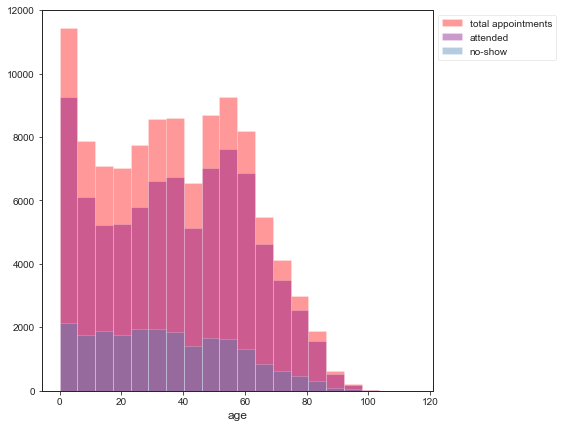

In [45]:
plt.figure(figsize=(7,7))
sns.distplot(df['age'], kde=False, bins=20,label='total appointments', color='red')
sns.distplot(attended['age'], kde=False, bins=20, label='attended', color='purple')
sns.distplot(didnt_show['age'], kde=False, bins=20, label='no-show', color='steelblue')

plt.legend(loc=2, bbox_to_anchor=(1,1));

***_Age Summary_***

Young children aged up to 5 years have the most appointments.   After a low point in number of appointments for the age group approximately 12-22 years the number increases fairly consistently to about age 57.  Following that a sharp and steady decline in the number of appointments for ages 60+.  What is interesting is the sharp dip in number of appointments for the age group 40-45.  This anomaly may need further investigation.

Another interesting observation is the number of no-shows from ages 0 to around 40 is pretty constant in absolute terms at around the 2000 mark, despite the fluctuation in number of appointments per age group.  Above 40, the number of no-shows steadily decrease for each age group, but at a slower rate than the decline in number of appointments.

As there are a higher number of appointments, the rate of no-show is lower for young children aged 5 years and under than for say 12-22 year olds and perhaps even 40-45 year olds.

This result could be helpful in allocating resources.  More staffing and resources could possibly be allocated to pediatricians and services for young children as they book the most appointments and have the best show up rate (thus it would be an efficient use of resources).  

On the other hand, better education and communication with the teens-early 20's age group could help increase their appointment attendances.

***
### Q2. Time vs. No-shows


1. Does the day of the week correlate with no-shows, for example, are patients likely to not turn up just before the weekend, or just after the weekend?
2. Does longer lead time (the period between scheduling an appointment and the actual appointment) relate to more no-shows, for reasons such as forgetting the appointment, or recovering before the appointment date and no longer needing to see a doctor? 
3. Can a reminder sms help lower the incidence of no-shows?


_First, columns will be added to the dataset_
* the day of the week of the appointment date (day_week)
* the number of days between 'scheduled_day' and 'appointment_day' (days_between)


In [46]:
# Insert 'day_week' column
df['day_week'] = df['appointment_day'].apply(lambda x: x.weekday())

In [47]:
# Map day names to day_week
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['day_week'] = df['day_week'].map(dmap)

In [48]:
# Insert 'days_between' column
df['days_between'] = df['appointment_day'] - df['scheduled_day']

In [49]:
df['days_between'].describe()

count                     106304
mean     10 days 09:48:36.195063
std      15 days 08:52:01.721380
min            -6 days +00:00:00
25%              0 days 00:00:00
50%              4 days 00:00:00
75%             15 days 00:00:00
max            179 days 00:00:00
Name: days_between, dtype: object

_'days between' should be equal to or greater than zero, as appointments are scheduled before the actual date_

In [50]:
# Check and delete any records where 'days_between' is negative
df[df['days_between']< '0 days' ]

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,day_week,days_between
27033,7.839273e+12,M,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,Mon,-1 days
55226,7.896294e+12,F,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,Tue,-1 days
64175,2.425226e+13,F,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,Wed,-1 days
71533,9.982316e+14,F,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,Thu,-6 days
72362,3.787482e+12,M,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,Tue,-1 days


** There are 5 records where 'days_between' is negative, i.e. 'appointment_day' is prior to 'scheduled_day'. 

All these appointments resulted in a no-show for our dataset but would have had nil effect on the actual day of the appointment.  At that time there was no appointment to be had so no resources were allocated to it. 

These records will be considered incorrect data and removed from the dataset **

In [51]:
df.drop(df[df['days_between']< '0 days'].index, inplace=True)
df[df['days_between']< '0 days' ]

,patient_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,day_week,days_between


***
#### 1. How does day of the week correlate to appointments and no-shows

_Plot week day and number of no-shows per day_

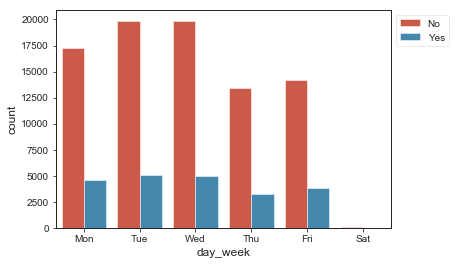

In [52]:
sns.countplot(x='day_week', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1));

In [53]:
# Tabular data of plotted graph
df.groupby(by=['day_week', 'no_show']).count()['age'].unstack()

no_show,No,Yes
day_week,,
Fri,14203,3859
Mon,17221,4580
Sat,30,9
Thu,13439,3267
Tue,19841,5033
Wed,19880,4937


In [54]:
# Tabular data of plotted graph
df.groupby(by=['day_week', 'no_show']).count()['age'].unstack()

no_show,No,Yes
day_week,,
Fri,14203,3859
Mon,17221,4580
Sat,30,9
Thu,13439,3267
Tue,19841,5033
Wed,19880,4937


***_Day of the Week Summary_***

The number of appointments are greater on Tuesday and Wednesday, quieting down Thursday and Friday to close to none on Saturday.  

Even with this variation of number of appointments over the days, the proportion of no-shows is approximately 1/5th of total appointments per day.

Therefore the day of the week does not correlate with appointment no-shows.  It does however give information on which days to possibly allocate additional resources in order to meet the higher demand for appointments.

***
#### 2. How does lead time correlate to appointments and no-shows

_Plot distribution of 'days between'_

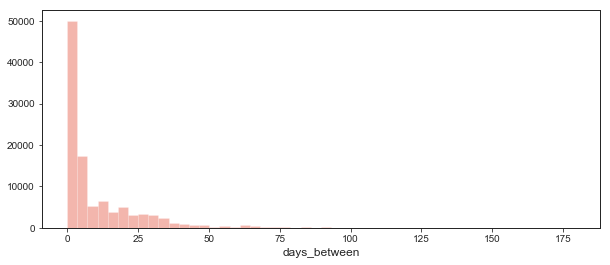

In [55]:
plt.figure(figsize=(10,4))
sns.distplot(df['days_between'].dt.days, kde=False);

** The distribution of 'days_between' scheduled and appointment date is skewed greatly to the right, with a high percentage of appointments occurring on the same day that it is scheduled.

A new column 'lead_time' will be created, grouping the 'days_between' as 0, 1, 2, 3, 4, 5, 6, 7, 7+, 14+, 21+, 28+ days **

In [56]:
#Insert new column 'lead_time'
bin_edges= [pd.Timedelta('-1 days'),
            pd.Timedelta('0 days'),
            pd.Timedelta('1 days'),
            pd.Timedelta('2 days'),
            pd.Timedelta('3 days'),
            pd.Timedelta('4 days'),
            pd.Timedelta('5 days'),
            pd.Timedelta('6 days'),
            pd.Timedelta('7 days'),
            pd.Timedelta('13 days'),
            pd.Timedelta('20 days'),
            pd.Timedelta('27 days'),
            df['days_between'].max()]

bin_names = [0,1,2,3,4,5,6,7,'7+','14+','21+','28+']

df['lead_time'] = pd.cut(df['days_between'], bin_edges, labels=bin_names)

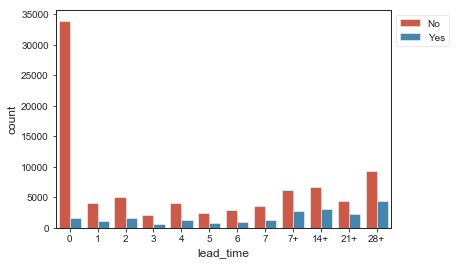

In [57]:
# Plot number of attendance and no-shows grouped by lead time
sns.countplot(x='lead_time', data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1));

** _Check whether the long lead times are incorrect data_ **

In [58]:
# Longest period between scheduled_day and appointment_day
df['days_between'].max()

Timedelta('179 days 00:00:00')

In [59]:
# No-shows for lead time of 179 days 
df[df['days_between']== df['days_between'].max()]['no_show'].value_counts()

No     8
Yes    2
Name: no_show, dtype: int64

In [60]:
# No-shows for lead time greater than 50 days
df[df['days_between']>= pd.Timedelta('50 days')]['no_show'].value_counts()

No     2284
Yes     980
Name: no_show, dtype: int64

***_Lead Time Summary_***

The vast majority of appointments are booked on the same day, resulting in mostly show ups. 

The data for long lead times greater than 50 days could be legitimate (maximum lead time is 179 days) as patients are showing up to these appointments.

If the appointment is booked in advance, by as little as just more than one week in advance, there is a higher proportion of no-shows compared with appointments booked in within the same week.  For appointments booked one week to 4+ weeks in advance, approximately 30% are missed.   Causes for missed appointments could be forgetting, recovering and no longer requiring the appointment or a clash with an unforeseen commitment.  

Strategies could therefore be put in place to target these advanced booked appointment holders.  

One such strategy is sending a reminder sms


***
#### 3. Can a reminder sms help lower the incidence of no-shows?

_Plot the number of no-shows categorized by whether an sms was received (1) or not(0)_

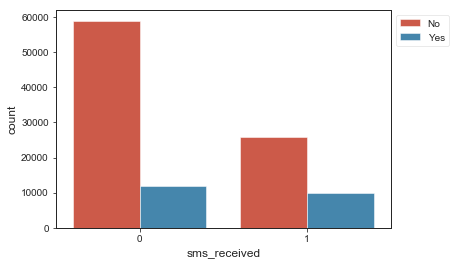

In [61]:
sns.countplot(x='sms_received', data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1));

In [62]:
#Tabular data of no-shows as a proportion of appointments where sms was sent vs. not sent
df.groupby('sms_received')['no_show'].value_counts(normalize=True)

sms_received  no_show
0             No         0.831924
              Yes        0.168076
1             No         0.724277
              Yes        0.275723
Name: no_show, dtype: float64

***_SMS Summary_***

In absolute terms, the difference in number of no shows for those that received an sms versus those that didn't is insignificant, no-show numbers hovering around 10,000.  However, taking into account that only one-third of appointments received an sms, the number of no-shows, given an sms reminder, is significant.  

27% of those that received an sms, were no-shows, while that is true for only 16% of those that didn't receive an sms.  This is counter-intuitive to the very idea of a reminder sms.  A follow up could determine how far in advance the sms's were sent - closer to the appointment day and a required reply could probably be more beneficial- and whether resources could be allocated to other reminder methods.


***Explore any trends relating lead time ('days_between'), sms reminders and no-shows***

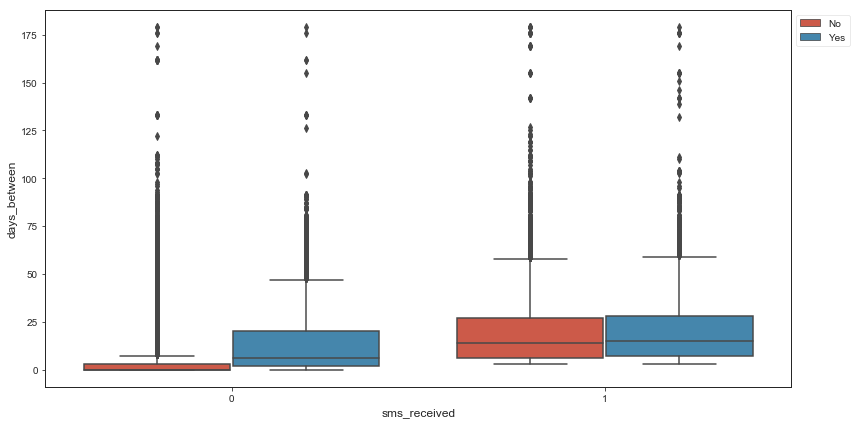

In [63]:
plt.figure(figsize=(12,6))
sns.boxplot(x='sms_received', y=df['days_between'].dt.days, data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.tight_layout();

***_SMS and Lead Time Summary_***

For those that received an sms, there is no significant difference between the correlation of lead time and show up rates.

Without an sms, 50% of no-shows occurred when the appointment was booked between 2 and 20 days beforehand.  

There is however a huge amount of outliers when analyszed with boxplots.

***
### Q3. Welfare vs. No-Shows
Are welfare holders more likely to attend an appointment for fear of possibly losing welfare entitlement due to too many missed medical appointments, or are non-welfare holders more likely to attend an appointment as they would possibly have to pay a no-show fee out of their own pocket.

In this plot, welfare holders are classified as 'scholarship' = 1, and non-welfare holders 'scholarship' = 0

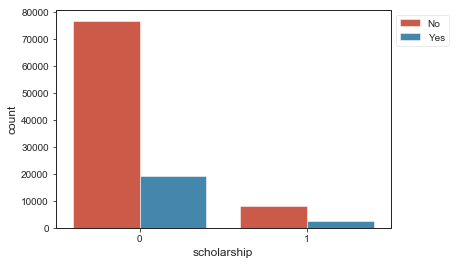

In [64]:
sns.countplot(x='scholarship', data=df, hue='no_show')
plt.legend(loc=2, bbox_to_anchor=(1,1));

In [65]:
# Tabular data of no-shows as a proportion of appointments held by welfare and non-welfare holders 
df.groupby('scholarship')['no_show'].value_counts(normalize=True)

scholarship  no_show
0            No         0.799789
             Yes        0.200211
1            No         0.761151
             Yes        0.238849
Name: no_show, dtype: float64

***Explore why welfare holders may have a higher no-show rate***

Perhaps welfare holders have to go on longer waiting lists for appointments and therefore lead-time could be a contributing factor.

In [66]:
df_welf_lead = df.groupby(by=['days_between','scholarship']).count()['appointment_day'].unstack()

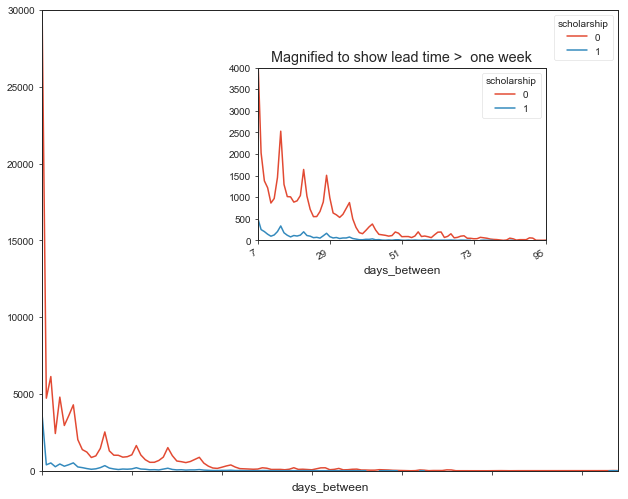

In [67]:
fig = plt.figure(figsize=(10,8))

axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
axes2 = fig.add_axes([0.4, 0.5, 0.4,0.3])

df_welf_lead.plot(ax=axes1, ylim=(0,30000))

df_welf_lead.plot(ax=axes2, xlim=(7,95), ylim=(0,4000))
axes2.set_xticks([7,29,51,73,95])
axes2.set_xticklabels([7,29,51,73,95])
axes2.set_title('Magnified to show lead time >  one week');

# Welfare holders => scholarship = 1; Non welfare => scholarship = 0

***_Welfare Summary_***

There is a slightly higher proportion (almost 4% of appointments) of no-shows for welfare holders as opposed to non-welfare holders.  This difference has not been tested for significance.

Further analysis did not support the hypothesis that welfare holders may have to go on longer waiting lists for appointments, thus bringing in the 'lead-time' effect for no-show.  The trend for lead time('days_between') was similar between welfare and non-welfare holders.

***
### Q4. Physical Traits and Ailments vs. No-Shows

Can a patient's physical traits or ailments be preventing them from attending a scheduled appointment?

_Summary plots of no-shows categorized by Hypertension, Diabetes, Alcoholism and Handicap, 1= patient affected by this trait, 0 = not affected_

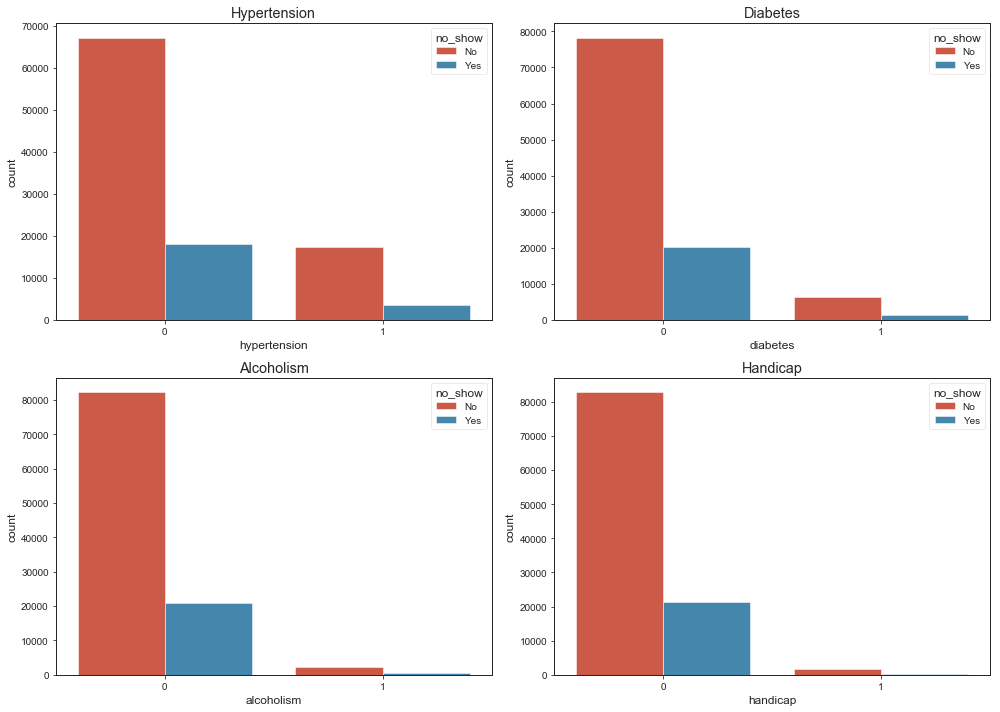

In [68]:
figure,axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

sns.countplot(x='hypertension', data=df, hue='no_show', ax=axes[0,0])
axes[0,0].set_title('Hypertension')

sns.countplot(x='diabetes', data=df, hue='no_show', ax=axes[0,1])
axes[0,1].set_title('Diabetes')

sns.countplot(x='alcoholism', data=df, hue='no_show', ax=axes[1,0])
axes[1,0].set_title('Alcoholism')

sns.countplot(x='handicap', data=df, hue='no_show', ax=axes[1,1])
axes[1,1].set_title('Handicap')

plt.tight_layout();

In [69]:
# Tabular data of no-shows as a proportion
print(df.groupby('hypertension')['no_show'].value_counts(normalize=True))
print(df.groupby('diabetes')['no_show'].value_counts(normalize=True))
print(df.groupby('alcoholism')['no_show'].value_counts(normalize=True))
print(df.groupby('handicap')['no_show'].value_counts(normalize=True))

hypertension  no_show
0             No         0.788608
              Yes        0.211392
1             No         0.825760
              Yes        0.174240
Name: no_show, dtype: float64
diabetes  no_show
0         No         0.794270
          Yes        0.205730
1         No         0.818053
          Yes        0.181947
Name: no_show, dtype: float64
alcoholism  no_show
0           No         0.796475
            Yes        0.203525
1           No         0.779496
            Yes        0.220504
Name: no_show, dtype: float64
handicap  no_show
0         No         0.795406
          Yes        0.204594
1         No         0.825224
          Yes        0.174776
Name: no_show, dtype: float64


***_Physical Traits Summary_***

Compared to Diabetes, Alcoholism and Handicap, a larger proportion of patients suffer from Hypertension.  Additionally, of those that suffer hypertension, their no-show ratio is slightly higher by about 3.7% than those that do not suffer.  This difference has not been tested for significance.

As mentioned in the Data Wrangling - Age section, the data of the higher aged patients, whose hypertension ratios were much higher than the general sample, may need to be re-visited to determine whether it could be slighlty skewing this result, should this difference of 3.7% prove to be significant. 

Of those that have a handicap, their no-show rate is also slighlty higher by about 2.5%.  This difference has not been tested for significance.  However this result could be further investigated by planners and carers to ensure hospitals and clinics are accessible for those with handicaps.  That mobility aids are provided and physical barriers are removed to allow those with handicaps to easily attend medical appointments and services.


<a id='conclusions'></a>
## Conclusions

The factors that seem to have some relation to whether a patient attends or doesn't attend a scheduled appointment are:

1. The lead time between scheduled and actual appointment, with longer lead time of 1 week and greater displaying a higher level of no-shows.   Strategies that might lower this rate could be explored, however the analysis on sms receipt in this project concluded that sms reminders had no effect on whether a patient would attend their appointment.  How Sms is used, such as how far in advance they were received or whether a reply was required could be explored.

2. Age groups to a certain extent, with young children under 5 having a higher attendance rate and teens-early 20s having a lower attendance rate.  Appointment rates were generally higher for the under 5's and could therefore warrant further resources allocated to these services.

3. Enrollment in the welfare program showed a slightly higher rate of no-shows.  Evidence could not be found to support the hypothesis that welfare holders are on longer wait lists for appointments thus this result could be skewed by 'lead-time' effect 

4. Physical traits hypertension and to a lesser extent handicap.  

Gender, the weekday of the appointment, diabetes and alcoholism did not show any relationship with no-shows in this analysis.

***
### Limitations

1. Differences were not tested for significance, such as for hypertension, handicap and welfare

2. 100k+ unique appointments, for only approximately 62k unique patient id's over a range of 27 appointment days, which averages to just under 2 appointments per patient.  Weeding out the partial duplicates were beyond my capabilities and therefore all remained in the dataset

***
### Further Investigation

1. It is beyond the scope of this project to analyse the correlation of the 81 neighbourhood and appointment no-shows.  It would be interesting to group these neighbourhoods further, perhaps by region or socio-economic to determine any trends.   Factors such as public transport, parking and even signage or facilities at the hospital could contribute to a missed appointment.

2. A cross analysis of factors could uncover more insights.  Such as analysis of neighbourhoods and accessibility of hospital and clinics for those with handicaps

3. Further analysis could be made on the likelihood a patient is a no-show given that they were previously a no-show.  Would the second appointment more likely be attended? 

4. Further work on this topic could explore whether initial or follow up appointments are more likely to be missed.




#### Resources
[Udemy Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/)

[Udacity Intro to Data Analysis](https://www.udacity.com/course/intro-to-data-analysis--ud170)

[Order axis of seaborn countplot](https://stackoverflow.com/questions/42846830/ordering-axis-of-seaborn-countplot)

[removing the timestamp link](https://stackoverflow.com/questions/45858155/removing-the-timestamp-from-a-datetime-in-pandas-dataframe)

[set_xticks vs set_xticklabels](https://stackoverflow.com/questions/21910986/why-set-xticks-doesnt-set-the-labels-of-ticks)

[replace values in column based on a condition](https://stackoverflow.com/questions/31511997/pandas-dataframe-replace-all-values-in-a-column-based-on-condition)